# Scipy Signal Processing

One of the greatest strengths of matlab is the included signal processing. The python scipy library has many of these capabilities and some are highlighted below. These have applications in electronics, microscopy, telescopy, radio, and many other fields.


By the end of this file you should have seen simple examples of:
1. Frequency decomposition via Fourier transforms
2. Feature detection via correlations
3. Convolution and deconvolution
4. Digital filtering of signal using infinite impulse response (IIR) and finite impulse response (FIR) filters

Further reading:  
https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html   
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html    
Filters:  
http://www.dummies.com/education/science/science-engineering/real-world-signals-and-systems-case-analog-filter-design-with-a-twist/   
http://radio.feld.cvut.cz/matlab/toolbox/signal/basics27.html    
IIR Filters:  
https://dspguru.com/dsp/faqs/iir/basics/      
https://www.dsprelated.com/showarticle/194.php   
FIR Filters:  
http://scipy-cookbook.readthedocs.io/items/ApplyFIRFilter.html   

 
 

In [1]:
import numpy as np               # Python numpy 
from scipy import signal, stats  # Python scipy signal package

from matplotlib import pyplot as plt   # Python matplotlib library
import matplotlib.gridspec as gridspec # Multiple plots in a single figure

# Display matplotlib in the notebook
%matplotlib inline 

%cd datafiles

C:\Users\bfleischer3\Dropbox (Personal)\PACE\Projects\Courses\IntroScientificPythonWithJupyter\datafiles


### Fourier Transform Examples

Fourier transforms are most often used to decompose a signal as a function of time into the frequency components that comprise it, e.g. transforming between time and frequency domains. It's also possible to post-process a filtered signal using Fourier transforms.

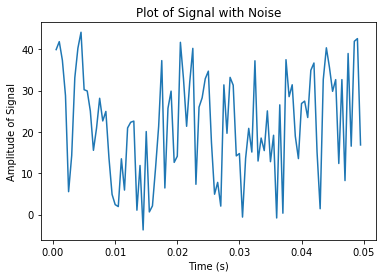

In [2]:
# Create signal
frq1 = 250                    # Frequency 1(hz)
amp1 = 3                      # Amplitude 1
frq2 = 50                     # Frequency 2(hz)
amp2 = 5                      # Amplitude 2
sr = 2000                     # Sample rate
dur = 0.4                       # Duration (s) (increasing/decreasing this changes S/N)

# Create signal and timesteps
X = np.linspace(0, dur-1/sr, int(dur*sr))  # Time
Y = amp1*np.sin(X*2*np.pi*frq1)+amp2*np.sin(X*2*np.pi*frq2)

# Add noise
Y_noise = Y + 40*np.random.rand(len(X))

plt.plot(X[1:100], Y_noise[1:100])
plt.title('Plot of Signal with Noise')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude of Signal')
plt.show()

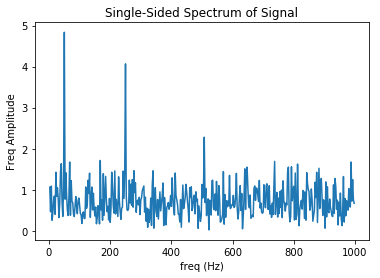

In [3]:
# Plot Single Sided FT Spectrum
Yfft = np.fft.fft(Y_noise)

# Update fft output
SSFT = Yfft[:int(len(Yfft)/2)]  # Index the first half (FFT is repeated)
SSFT = np.abs(SSFT)             # Use the absolute Value
SSFT = SSFT/len(X) * 2          # Normalize and double the values (FFFT is repeated)

# Determine frequencies
freqs = sr*np.arange(0,len(SSFT))/(len(Y))

# Plot
plt.plot(freqs[1:], SSFT[1:])
plt.title('Single-Sided Spectrum of Signal')
plt.xlabel('freq (Hz)')
plt.ylabel('Freq Amplitude')
plt.show()

The amplitudes don't seem quite right - longer duration increases the signal to noise and gives a better result:

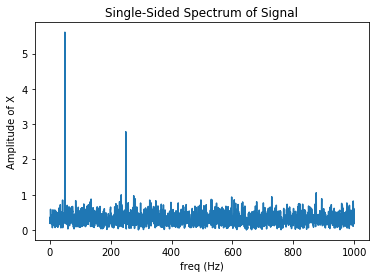

In [4]:
# Create signal
sr = 2000                      # Sample rate
dur = 2  # Increased duration (s) (increasing/decreasing this changes S/N)
X = np.linspace(0, dur-1/sr, int(dur*sr))  # Time
Y = amp1*np.sin(X*2*np.pi*frq1)+amp2*np.sin(X*2*np.pi*frq2)
Y_noise = Y + 40*np.random.rand(len(X))

# Determine Single Sided FT Spectrum
Yfft = np.fft.fft(Y_noise)
SSFT = Yfft[:int(len(Yfft)/2)] # Index the first half
SSFT = np.abs(SSFT)             # Use the absolute Value
SSFT = SSFT/len(X) * 2          # Normalize and double the values (FFT is wrapped)
freqs = sr*np.arange(0,len(SSFT))/len(Y)

# Plot
plt.plot(freqs[1:], SSFT[1:])
plt.title('Single-Sided Spectrum of Signal')
plt.xlabel('freq (Hz)')
plt.ylabel('Amplitude of X')
plt.show()

### Notch Filter

Plot our original, non-noisy two-component signal:

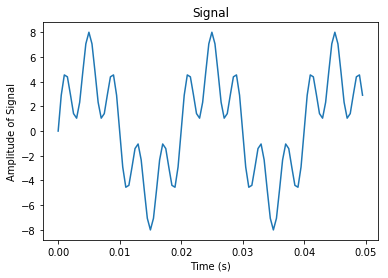

In [5]:
# Plot
plt.plot(X[:100],Y[:100])
plt.title('Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude of Signal')
plt.show()

Perform the Fourier transform, and set the 200 Hz signal to zero:

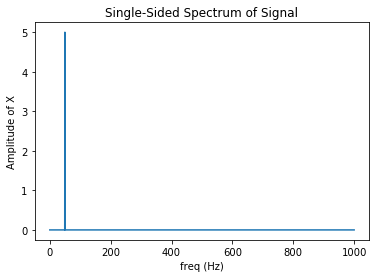

In [6]:
# Fourier transform
Yfft = np.fft.fft(Y); 

freqs = sr*np.arange(0,len(Yfft)/2)/len(Y) # Frequencies of the FT
ind250Hz = np.where(freqs==250)[0][0] # Index to get just 250 Hz Signal 

Y_filt = Yfft[:] # The original, non-absolute, full spectrum is important
full_w = 200     # Width of spectrum to set to zero

# Set FT at frequency to zero
Y_filt[ind250Hz-int(full_w/2):ind250Hz+int(full_w/2)] = 0 # Set the 250 Hz signal (+-) to zero on the lower side
Y_filt[-ind250Hz-int(full_w/2):-ind250Hz+int(full_w/2)] = 0 # Set the 250 Hz signal (+-) to zero on the upper side

# Determine single sided Fourier transform
SSFT_filt = Y_filt[:int(len(Y_filt)/2)]   # Index the first half
SSFT_filt = np.abs(SSFT_filt)             # Use the absolute Value
SSFT_filt = SSFT_filt/len(X) * 2          # Normalize and double the values (FFT is wrapped)

# Plot
plt.plot(freqs[1:], SSFT_filt[1:]) 
plt.title('Single-Sided Spectrum of Signal')
plt.xlabel('freq (Hz)')
plt.ylabel('Amplitude of X')
plt.show()

Inverse Fourier transform back, and plot the original filtered signal:

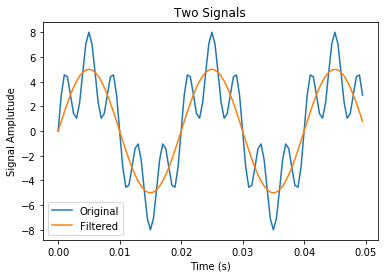

In [7]:
# Inverse FFT the original, non-absolute, full spectrum
Y2 = np.fft.ifft(Y_filt) 
Y2 = np.real(Y2) # Use the real values to plot the filtered signal

# Plot
plt.plot(X[:100],Y[:100], label='Original')
plt.plot(X[:100],Y2[:100], label='Filtered')
plt.title('Two Signals')
plt.xlabel('Time (s)')
plt.ylabel('Signal Amplutude')
plt.legend(loc='best')
plt.show()

While the Fourier amplitudes properly represent the amplitude of frequency components, the power spectral density (square of the discrete fourier transform) can be estimated using a periodogram:

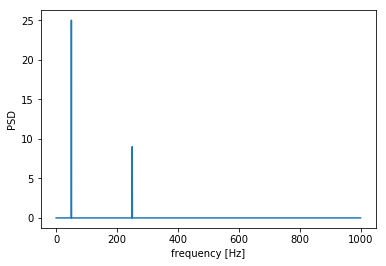

In [8]:
# Determine approx power spectral density
f, Pxx_den = signal.periodogram(Y, sr)

# Plot
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

## Correlation

Correlations are a measure of the product of two signals as a function of the x-axis shift between them. They are often used to determine similarity between the two signals, e.g. is there some structure or repeating feature that is present in both signals?


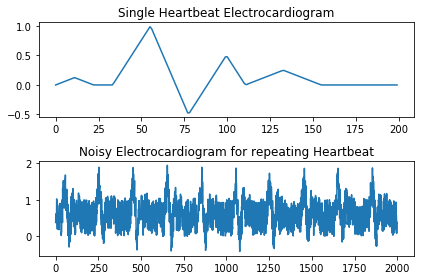

In [9]:
# Create a signal
npts = 200
heartbeat = np.asarray([0,1,0,0,4,8,2,-4,0,4,0,1,2,1,0,0,0,0])/8
xvals  = np.linspace(0,len(heartbeat),npts)
heartbeat = np.interp(xvals,np.arange(0,len(heartbeat)),heartbeat) # Use interpolation to spread the signal out

# Repeat the signal ten times, add some noise:
hrtbt = np.tile(heartbeat,10)
hrtbt_noise = hrtbt + np.random.rand(len(hrtbt))

# Plot
G = gridspec.GridSpec(2, 1)               
axis1 = plt.subplot(G[0, 0])
axis1.plot(heartbeat)
axis1.set_title('Single Heartbeat Electrocardiogram')

axis2 = plt.subplot(G[1, 0])
axis2.plot(hrtbt_noise)
axis2.set_title('Noisy Electrocardiogram for repeating Heartbeat')

plt.tight_layout()
plt.show()

The center of the repeating (heartbeat) signal is marked as a centroid:

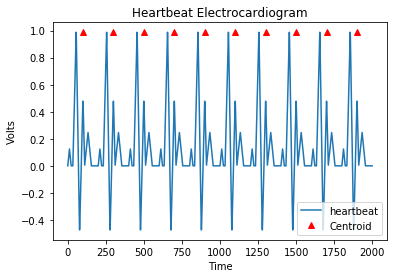

In [10]:
# Find center of each repeating signal
cent_x = np.arange(1,11)*200 - 100
cent_y = np.ones(10)*max(hrtbt)

# Plot
plt.plot(hrtbt[:], label='heartbeat')
plt.plot(cent_x[:],cent_y[:],'r^', label='Centroid')
plt.title('Heartbeat Electrocardiogram')
plt.xlabel('Time')
plt.ylabel('Volts')
plt.legend(loc='best')
plt.show()

Correlate the single signal with the repeating, noisy one:

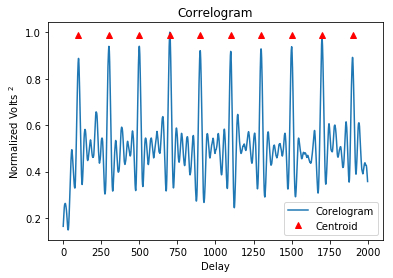

In [11]:
# Correlate
corr = signal.correlate(hrtbt_noise, heartbeat, mode='same')

# Plot
plt.plot(corr/max(corr), label='Corelogram')
plt.plot(cent_x,cent_y,'r^', label='Centroid')
plt.title('Correlogram')
plt.xlabel('Delay')
plt.ylabel('Normalized Volts $^2$')
plt.legend(loc='best')
plt.show()

The correlogram recovered the repeating signal central points. This is because at these points, the signal has the greatest similarity with the rectangular pulse. In other words, we're recovering the areas that share the greatest amount of similarity with our rectangular pulse.

## Convolution

Convolution is a process in which the shape of one function is expressed in another. They're useful for adjusting features, or representing real-world measurements if the response of the filter or instrument is known.

As an example, consider a 1 dimensional image taken by an optical microscope (here, a sawtooth wave). The microscope itself imposes empirical limitations in the optics they use approximated by a Gaussian point squared function (PSF). The final image is the convolution of the original image and the PSF.

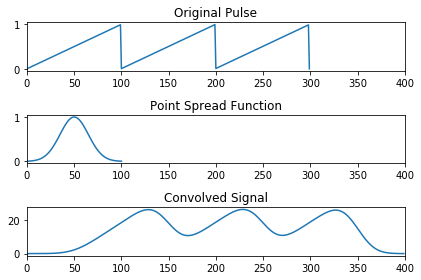

In [12]:
# Signal and PSF
orig_sig = signal.sawtooth(2*np.pi*np.linspace(0,3,300))/2+0.5 
psf = signal.gaussian(101, std=15)                          

# Convolve
convolved = signal.convolve(orig_sig, psf) 

# Plot
G = gridspec.GridSpec(3, 1)                
axis1 = plt.subplot(G[0, 0])
axis1.plot(orig_sig)
axis1.set_xlim(0, len(convolved))
axis1.set_title('Original Pulse')

axis2 = plt.subplot(G[1, 0])
axis2.plot(psf)
axis2.set_xlim(0, len(convolved))
axis2.set_title('Point Spread Function')

axis3 = plt.subplot(G[2, 0])
axis3.plot(convolved)
axis3.set_xlim(0, len(convolved))
axis3.set_title('Convolved Signal')

plt.tight_layout()
plt.show()

## Deconvolution
Deconvolution can be thought of as removing the filter or instrument response. This is pretty common when reconstructing real signals if the response is known.

In the microscope example, this would be deconvolving image with a known response of the instrument to a point source. If it is known how much the entire image is spread out, the original image can be recovered.

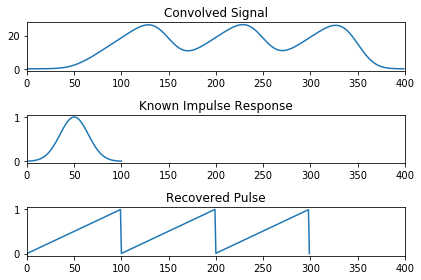

In [13]:
# Deconvolve
recovered, remainder = signal.deconvolve(convolved, psf)

# Plot
G = gridspec.GridSpec(3, 1)                              
axis1 = plt.subplot(G[0, 0])
axis1.plot(convolved)
axis1.set_xlim(0, len(convolved))
axis1.set_title('Convolved Signal')

axis2 = plt.subplot(G[1, 0])
axis2.plot(psf)
axis2.set_xlim(0, len(convolved))
axis2.set_title('Known Impulse Response')

axis3 = plt.subplot(G[2, 0])
axis3.plot(recovered)
axis3.set_xlim(0, len(convolved))
axis3.set_title('Recovered Pulse')

plt.tight_layout()
plt.show()

## Filtering  

Filters recieve a signal input and selectively reduce the amplitude of certain frequencies. Working with digital signals, they can broadly be divided into infinitie impulse response (IIR) and finite impulse response (FIR).

IIR filters that receive an impulse response (signal of value 1 followed by many zeros) yield a (theoretically) infinite number of non-zero values.

This is in contrast with the the finite impulse response (FIR) filter that receives an impulse response and does become exactly zero beyond the duration of the impulse.

### Infinite Impulse Response (IIR) filters  
First, we generate a signal and approximate the power spectral density (PSD):

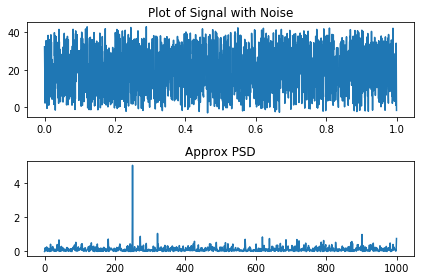

In [14]:
frq1 = 250                    # Frequency 1(hz)
amp1 = 3                      # Amplitude 1
sr = 2000                     # Sample rate
dur = 1                       # Duration (s) (increasing/decreasing this changes S/N)

# Create timesteps, signal and noise
X = np.linspace(0, dur-1/sr, int(dur*sr))  # Time
Y = amp1*np.sin(X*2*np.pi*frq1)            # Signal
Y_noise = Y + 40*np.random.rand(len(X))    # Add noise

# Approx PSD
f, Pxx_den = signal.periodogram(Y_noise, sr) 

# Plot
G = gridspec.GridSpec(2, 1) 
axis1 = plt.subplot(G[0, 0])
axis1.plot(X, Y_noise)
axis1.set_title('Plot of Signal with Noise')

axis2 = plt.subplot(G[1, 0])
axis2.plot(f, Pxx_den)
axis2.set_title('Approx PSD')

plt.tight_layout()
plt.show()

Digital filters inherently account for digital signal limitations, i.e. the sampling frequency. The Nyquist theorem asserts that we can't measure frequencies that are higher than 1/2 the sampling frequency, and the digital filter operates on this principle.

Next, we create the digital filter and plot the response:

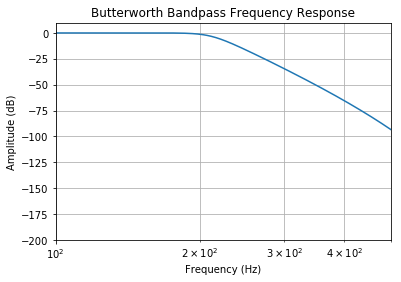

In [15]:
f_order = 10.0             # Filter order
f_pass = 'low'           # Filter is low pass
f_freq = 210.0             # Frequency to pass
f_cutoff = f_freq/(sr/2) # Convert frequency into 

# Create the filter
b, a = signal.iirfilter(f_order, f_cutoff, btype=f_pass, ftype='butter') 
w, h = signal.freqz(b, a, 1000)  # Test response of filter across fqurencies (Use 'freqz' for digital)
freqz_hz = w * sr / (2 * np.pi)  # Convert frequency to Hz
resp_db = 20 * np.log10(abs(h))  # Convert response to decibels

# Plot filter response
plt.semilogx(freqz_hz, resp_db ) 
plt.title('Butterworth Bandpass Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.axis((100, 500, -200, 10))
plt.grid(which='both', axis='both')
plt.show()

Applying the filter to our signal filters all higher frequencies:

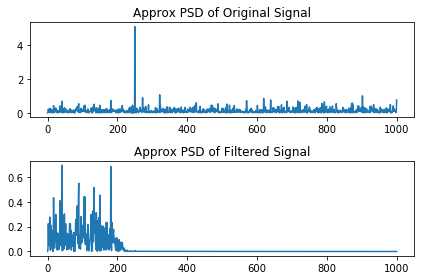

In [16]:
# Filter signal
sig_filtered = signal.filtfilt(b, a, Y_noise)  
# Determine approx PSD
f, Pxx_den_f = signal.periodogram(sig_filtered, sr) 

# Plot
G = gridspec.GridSpec(2, 1) 
axis1 = plt.subplot(G[0, 0])
axis1.plot(f, Pxx_den)
axis1.set_title('Approx PSD of Original Signal')

axis2 = plt.subplot(G[1, 0])
axis2.plot(f, Pxx_den_f)
axis2.set_title('Approx PSD of Filtered Signal')

plt.tight_layout()
plt.show()

## Finite Impulse Response Filters

A finite impulse response (FIR) filter can be designed where a linear phase response is specified within specified regions (up to the Nyquist or 1/2 of the sampling frequency).

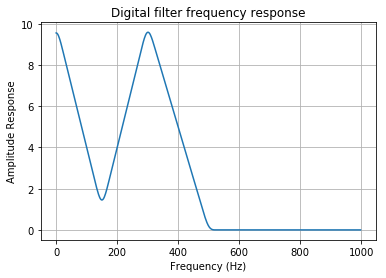

In [17]:
# Create FIR Filter
taps = 150                           # Analogus to IIR order - indication of memory, calculation, and 'filtering'
freqs = [0, 150, 300, 500, sr/2.]    # FIR frequencies
ny_fract = np.array(freqs)/(sr/2)    # Convert frequency to fractions of the Nyquist freq
gains = [10.0, 1.0, 10.0, 0.0, 0.0]  # Gains at each frequency

b = signal.firwin2(taps, ny_fract, gains) # Make the filter (there are no 'a' coefficients)
w, h = signal.freqz(b)                    # Check filter response

freqz_hz = w * sr / (2 * np.pi) # Convert frequency to Hz
resp_db = 20 * np.log10(abs(h)) # Convert response to decibels

# Plot filter response
plt.title('Digital filter frequency response')
plt.plot(freqz_hz, np.abs(h))
plt.title('Digital filter frequency response')
plt.ylabel('Amplitude Response')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.show()

And the effect of the FIR digital filter:

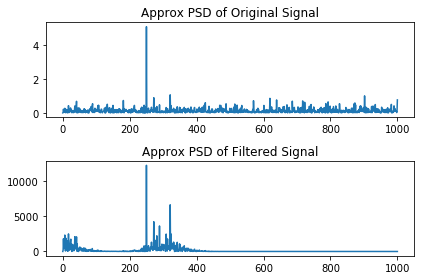

In [18]:
# Filter Signal
sig_filtered = signal.filtfilt(b, 1, Y_noise) 
# Determine approx PSD
f, Pxx_den_f = signal.periodogram(sig_filtered, sr)

# Plot
G = gridspec.GridSpec(2, 1)                         
axis1 = plt.subplot(G[0, 0])
axis1.plot(f, Pxx_den)
axis1.set_title('Approx PSD of Original Signal')

axis2 = plt.subplot(G[1, 0])
axis2.plot(f, Pxx_den_f)
axis2.set_title('Approx PSD of Filtered Signal')

plt.tight_layout()
plt.show()

Interestingly, the FIR filter can be replicated by convolutions. A set of related benchmarks relating to that property is available here: 

http://scipy-cookbook.readthedocs.io/items/ApplyFIRFilter.html